# LSTM 피쳐 예측 시도
---

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, GRU
from keras.losses import Huber
from keras.optimizers import Adam

## [1] 데이터 로딩
---

In [98]:
# input 데이터 로딩
data_tomato = pd.read_csv("./data/data_tomato.csv", index_col=0)
data_qva = pd.read_csv("./data/data_qva_inter.csv", index_col=0)
data_rv = pd.read_csv("./data/data_rv.csv", index_col=0)

data = pd.concat([data_tomato, data_qva, data_rv], axis=1)
data.head()

,TCL_AT,TCL_LT,TCL_HT,TEMP_EF_CAP,TEMP_EF_DONGNAM,TEMP_EF_DAEGYUNG,TEMP_EF_CHOONG,TEMP_EF_HONAM,TEMP_EF_MEAN,POWER_WATER,...,ELEC_SERVICE,ELEC_CIVIL_SUM,ELEC_ARGRI_FISHING,ELEC_MINING,ELEC_MANUFACT,ELEC_INDSUM,QVA,RV,GAS_PRICE_IND,OIL_PRICE
DATE,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,363291,...,3616542,6988059,301811,80421,8854576,9236808,36550.300000,0.97,26.94,27.86
1996-02-01,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,356379,...,3551611,6898533,327617,70471,8067220,8465308,36751.000000,0.93,26.94,29.04
1996-03-01,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,362980,...,3333225,6416945,345359,81877,9250086,9677322,36951.700000,0.96,26.94,27.99
1996-04-01,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,367415,...,3430624,6615182,292235,84596,9274014,9650845,37152.400000,0.94,26.94,28.74
1996-05-01,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,440662,...,3333483,6370027,302913,80963,9274169,9658045,37365.733333,0.92,26.94,29.18


In [122]:
# target 데이터 로딩
target = pd.read_csv("./data/target.csv", index_col=0)

target_ind = target.iloc[:, 1]
target_civil = target.iloc[:, 0]

date = target.index

## [2] 데이터 전처리
---

### [2-1] 데이터 정규화

In [100]:
scaler = MinMaxScaler()
data_scaler = scaler.fit(data)

scale_cols = list(data.columns)

data_scaled = data_scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=scale_cols)
data_scaled.head()

,TCL_AT,TCL_LT,TCL_HT,TEMP_EF_CAP,TEMP_EF_DONGNAM,TEMP_EF_DAEGYUNG,TEMP_EF_CHOONG,TEMP_EF_HONAM,TEMP_EF_MEAN,POWER_WATER,...,ELEC_SERVICE,ELEC_CIVIL_SUM,ELEC_ARGRI_FISHING,ELEC_MINING,ELEC_MANUFACT,ELEC_INDSUM,QVA,RV,GAS_PRICE_IND,OIL_PRICE
0,0.119401,0.211867,0.059217,0.962362,0.843924,0.842862,0.836159,0.803336,0.897574,0.165935,...,0.024189,0.032655,0.008191,0.089819,0.057683,0.049688,0.009127,0.576471,0.0,0.000000
1,0.120178,0.202764,0.092605,0.944191,0.823706,0.826438,0.819845,0.785243,0.879284,0.159738,...,0.018796,0.027925,0.024838,0.038433,0.005028,0.002813,0.011378,0.529412,0.0,0.006917
2,0.154554,0.246586,0.091354,0.829553,0.614455,0.630423,0.613482,0.569850,0.717359,0.165656,...,0.000659,0.002479,0.036284,0.097338,0.084134,0.076453,0.013628,0.564706,0.0,0.000762
3,0.187260,0.264731,0.145515,0.626857,0.378784,0.409702,0.337924,0.270990,0.482756,0.169633,...,0.008748,0.012953,0.002014,0.111380,0.085734,0.074844,0.015879,0.541176,0.0,0.005159
4,0.231290,0.316306,0.172376,0.280936,0.298854,0.329730,0.236877,0.177441,0.256523,0.235305,...,0.000681,0.000000,0.008902,0.092618,0.085744,0.075281,0.018271,0.517647,0.0,0.007738


### [2-2] 데이터 스플릿

In [128]:
# 예측할 컬럼 뽑아서 train, test로 나누기
COL = 'ELEC_MANUFACT'

data_train, data_test, date_train, date_test = train_test_split(
    data_scaled[COL], date, shuffle=False, test_size=0.2
)

In [129]:
data_train.shape, data_test.shape

((240,), (60,))

In [130]:
# 날짜 데이터 형식 변환
date_train = pd.to_datetime(date_train)
date_test = pd.to_datetime(date_test)

### [2-3] 시퀀스 데이터셋

In [131]:
def windowed_dataset(X, window_size, batch_size, shuffle):
    X = tf.expand_dims(X, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(X)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(50)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [132]:
# 파라미터 세팅 및 데이터셋 생성
WINDOW_SIZE = 6
BATCH_SIZE = 32

ds_train = windowed_dataset(data_train, WINDOW_SIZE, BATCH_SIZE, True)
ds_test = windowed_dataset(data_test, WINDOW_SIZE, BATCH_SIZE, False)

In [133]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in ds_train.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 6, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## [3] 모델 생성
---

In [158]:
def make_model(units):
    model = Sequential([
        # 1차원 feature map 생성
        Conv1D(filters=32, kernel_size=3,
               padding="causal",
               activation="relu",
               input_shape=[WINDOW_SIZE, 1]),
        # LSTM
        LSTM(units, return_sequences=True),
        LSTM(units),
        Dense(units, activation="relu"),
        Dense(1),
    ])

    # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
    loss = Huber()
    optimizer = Adam(0.0005)
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
    
    return model

In [159]:
model = make_model(32)

In [160]:
model.fit(
    ds_train,
    validation_data=(ds_test),
    epochs=50,
    verbose=False
)

In [161]:
pred = model.predict(ds_test)
pred.shape

2/2 [==============================] - 0s 11ms/step


(54, 1)

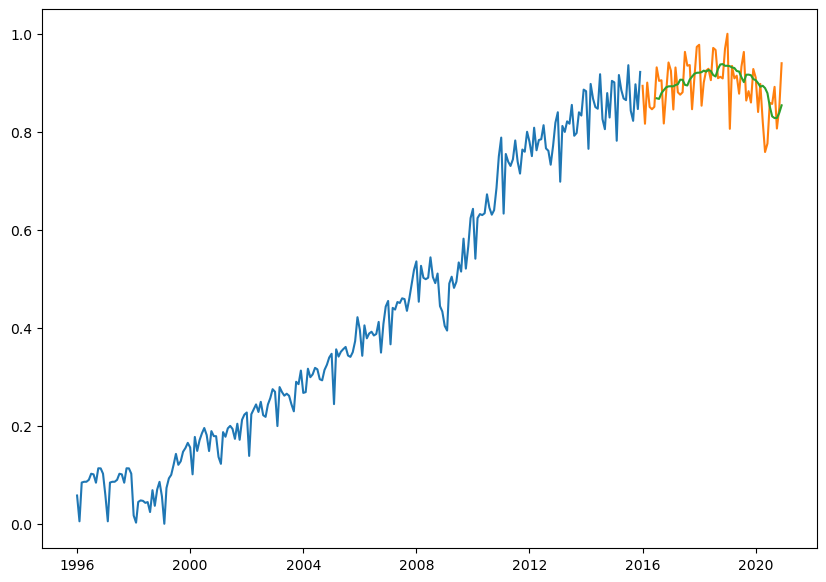

In [162]:
plt.figure(figsize=(10, 7))
plt.plot(date_train, data_train)
plt.plot(date_test, data_test)
plt.plot(date_test[6:], list(pred))
plt.show()